# Dynamics via acceleration maps

- `medium` dataset has `n_stats = 500`
- `large` dataset has `n_stats = 250`


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from analysis import analysis

mu_factor = 6  # conversion to microns
min_factor = 8  # conversion to minutes
n_stats = 250  # delta between each recorded observation
dt = n_stats * 0.002 * min_factor / 60  # dt between each recorded observation, in hr


#### Load grid by grid
- Load `fulltake_gid*.pkl`, which is all of the runs for a config

In [2]:
from glob import glob

files = glob("data/large/fulltake_gid*.pkl")
data = []
for file in files:
    df = pd.read_pickle(file)
    df.x *= mu_factor
    df.y *= mu_factor
    data.append(df)

print(f"Loaded {len(data)} configurations.")
[
    print(
        f"\t - Grid {gid}: {len(df)} total data points | {len(df.rid.unique())} runs | {len(df[df.rid==0])} data points / run"
    )
    for gid, df in zip(range(8), data)
]
display(data[0])


Loaded 8 configurations.
	 - Grid 0: 1382400 total data points | 1152 runs | 1200 data points / run
	 - Grid 1: 1382400 total data points | 1152 runs | 1200 data points / run
	 - Grid 2: 1382400 total data points | 1152 runs | 1200 data points / run
	 - Grid 3: 1382133 total data points | 1152 runs | 1200 data points / run
	 - Grid 4: 1382400 total data points | 1152 runs | 1200 data points / run
	 - Grid 5: 1377768 total data points | 1152 runs | 1198 data points / run
	 - Grid 6: 1382400 total data points | 1152 runs | 1200 data points / run
	 - Grid 7: 1134162 total data points | 966 runs | 1159 data points / run


,x,y,vx,vy,time[hr],D,beta,tau,gid,rid
0,75.000000,150.000000,0.000000,0.000000,0.000000,0.1,0.6,1.0,0,460
1,75.130202,149.819730,0.067558,-0.134345,0.066667,0.1,0.6,1.0,0,460
2,75.452823,149.518449,0.150165,-0.062928,0.133333,0.1,0.6,1.0,0,460
3,75.963937,149.423587,0.140960,0.043654,0.200000,0.1,0.6,1.0,0,460
4,76.561363,149.446742,0.315420,0.092189,0.266667,0.1,0.6,1.0,0,460
...,...,...,...,...,...,...,...,...,...,...
1195,219.322876,148.552330,0.245386,-0.029189,79.666667,0.1,0.6,1.0,0,1122
1196,220.126422,148.796841,0.262041,0.214830,79.733333,0.1,0.6,1.0,0,1122
1197,220.677016,149.604271,0.146369,0.256110,79.800000,0.1,0.6,1.0,0,1122
1198,221.050027,150.465492,0.045329,0.216606,79.866667,0.1,0.6,1.0,0,1122


### Position dist

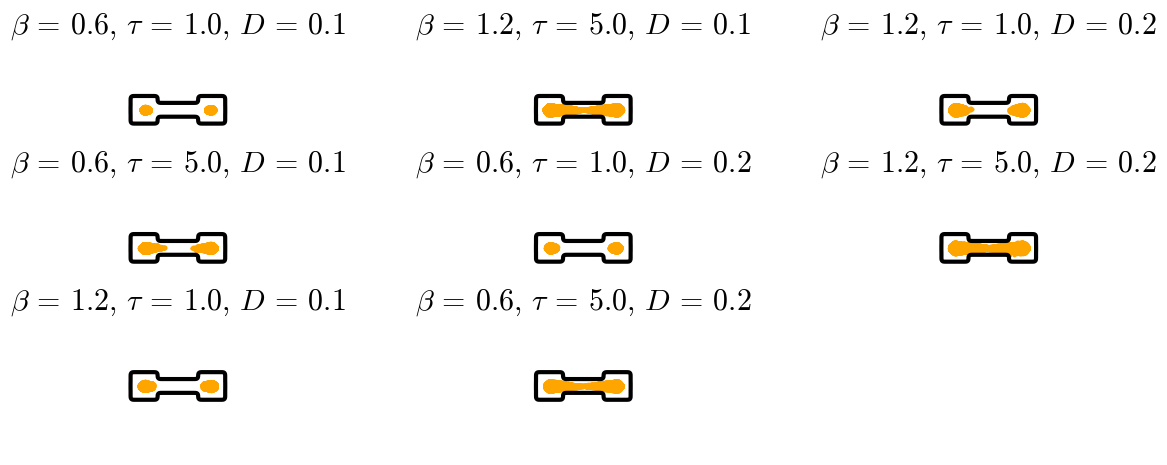

In [3]:
analysis.position_dist(data, mu_factor)

### Hopping times

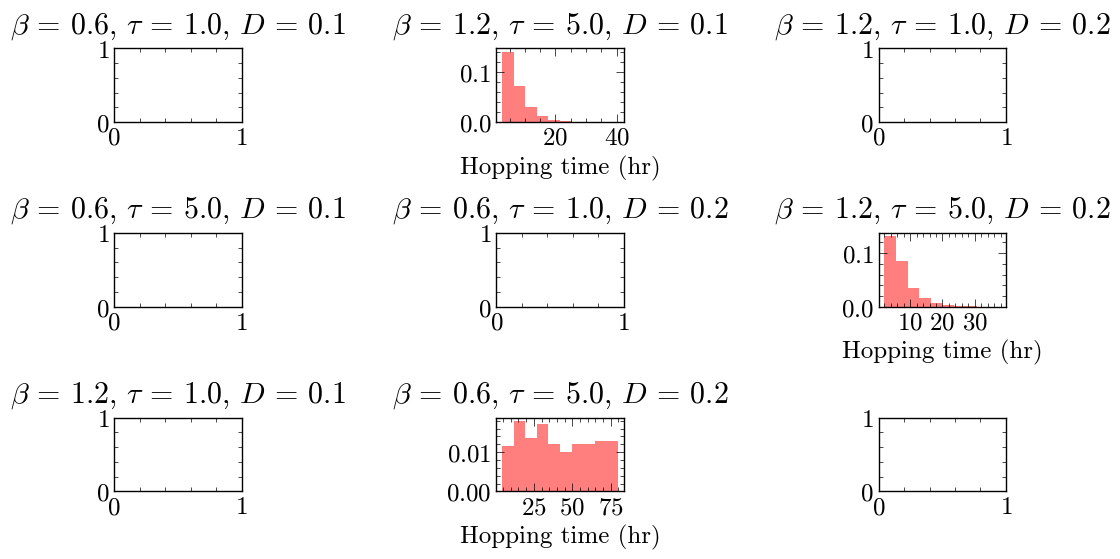

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(10, 6))

x, y = np.meshgrid([0, 1, 2], [0, 1, 2])

for i, j, df in zip(x.flatten(), y.flatten(), data):
    beta = df.beta.iloc[0]
    tau = df.tau.iloc[0]
    D = df.D.iloc[0]
    axs[i, j].set_title(rf"$\beta$ = {beta}, $\tau$ = {tau}, $D$ = {D}", y=1.1)

    hop_times = []
    for rid, d in df.groupby("rid"):
        for t in analysis.get_hopping_times(d, mu_factor):
            hop_times.append(t)

    if len(hop_times) == 0:
        continue

    axs[i, j].hist(hop_times, color="red", alpha=0.5, density=True)
    axs[i, j].set_xlabel("Hopping time (hr)")
        
plt.tight_layout()
plt.subplots_adjust(hspace=1.5, wspace=2)
plt.show()


## Map bin statistics

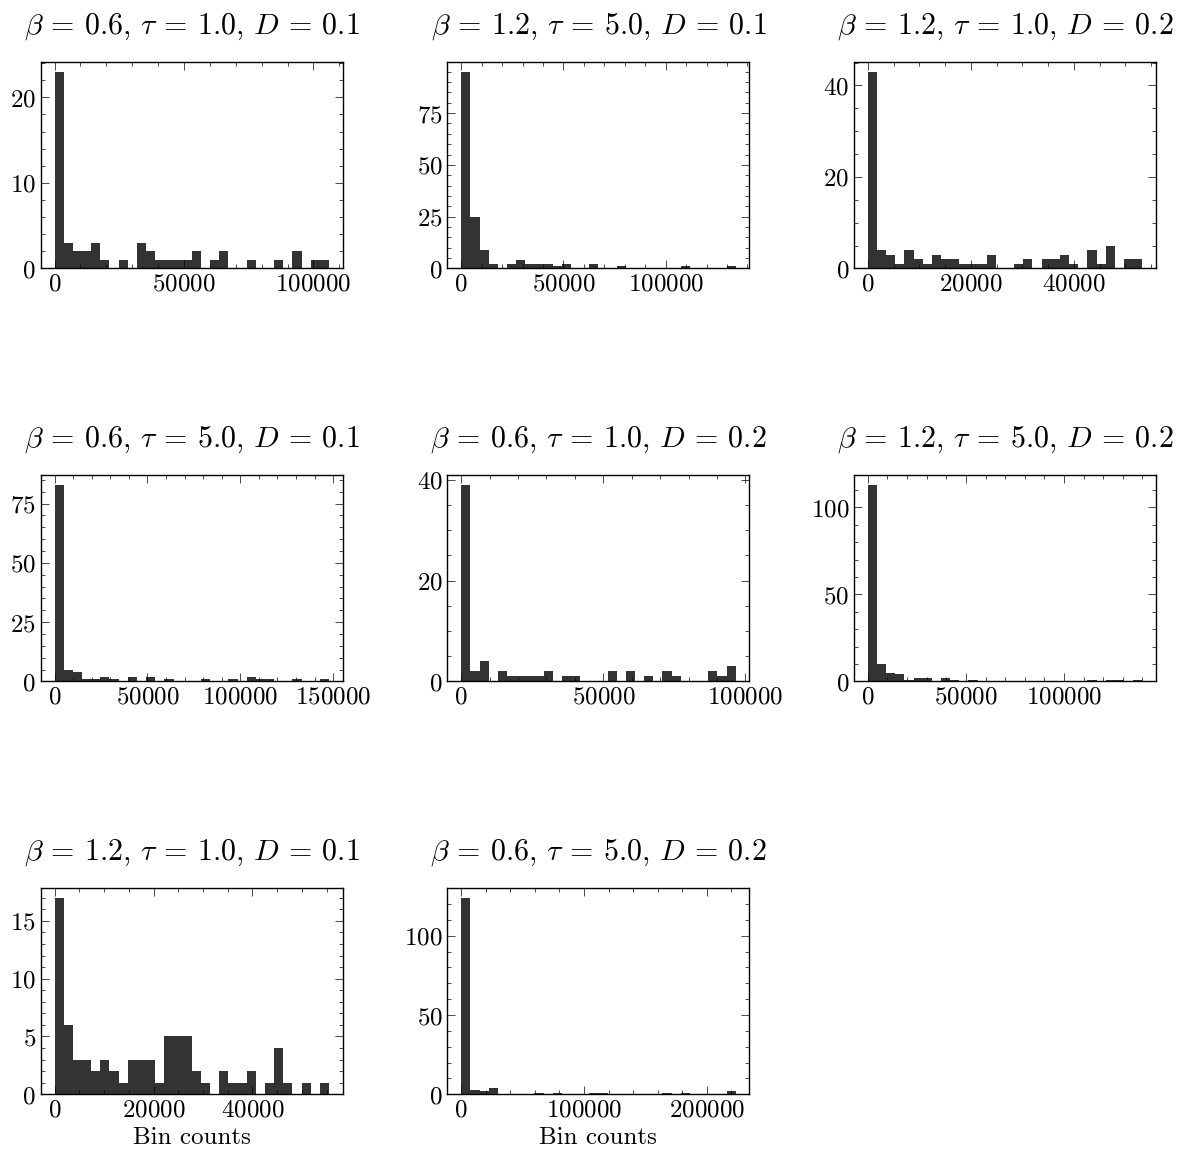

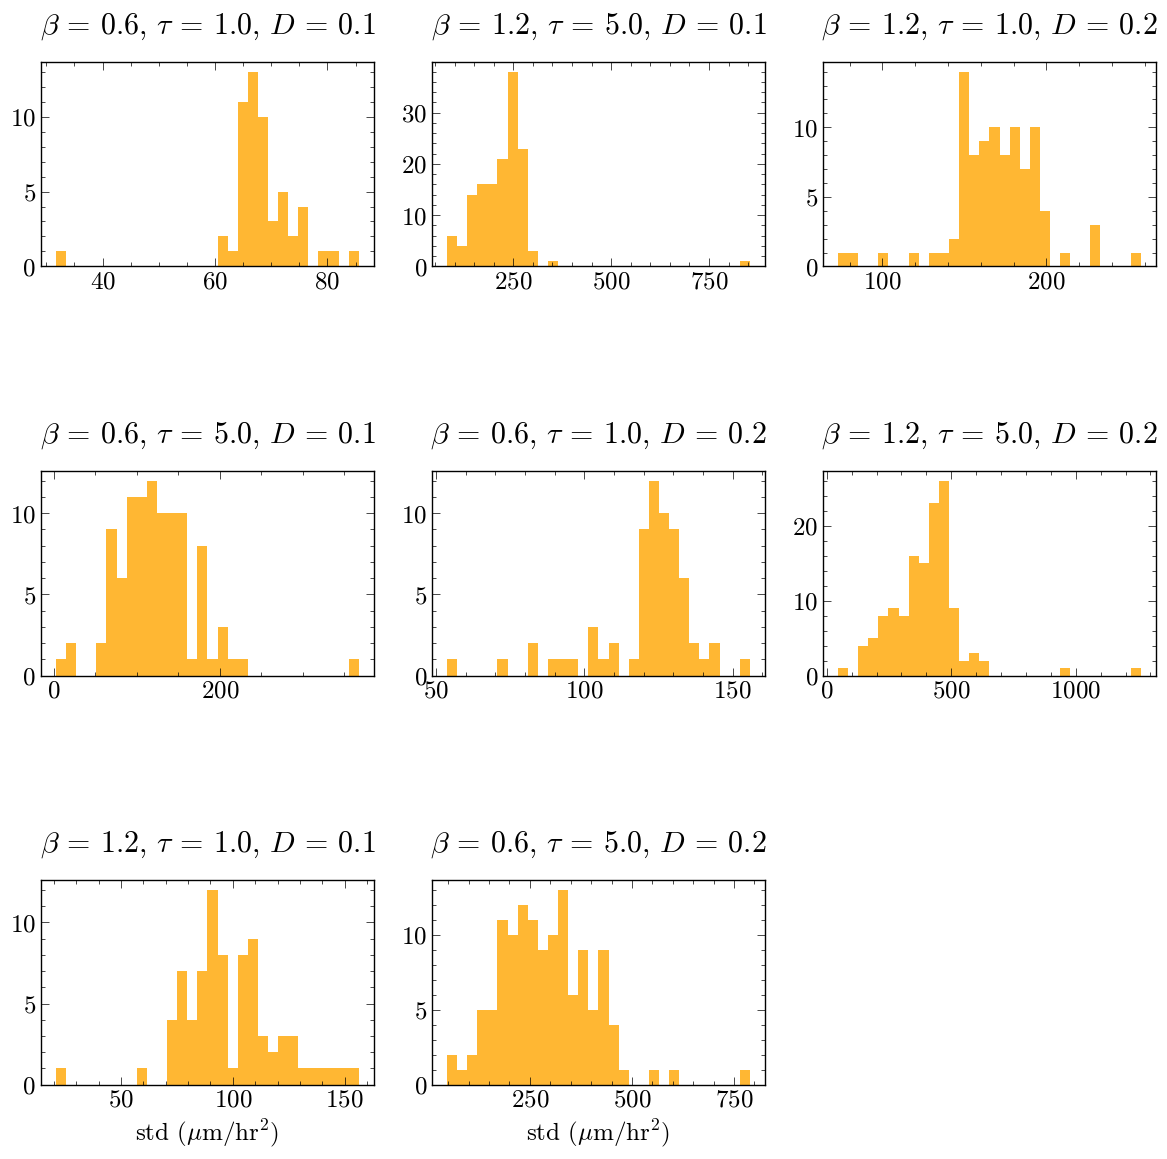

In [5]:
fig1, axs1 = plt.subplots(3, 3, figsize=(12, 12))
fig2, axs2 = plt.subplots(3, 3, figsize=(12, 12))

x, y = np.meshgrid([0, 1, 2], [0, 1, 2])
global_x_v_a = []

for i, j, df_gid in zip(x.flatten(), y.flatten(), data):
    beta = df_gid.beta.iloc[0]
    tau = df_gid.tau.iloc[0]
    D = df_gid.D.iloc[0]
    axs1[i, j].set_title(rf"$\beta$ = {beta}, $\tau$ = {tau}, $D$ = {D}", y=1.1)
    axs2[i, j].set_title(rf"$\beta$ = {beta}, $\tau$ = {tau}, $D$ = {D}", y=1.1)

    # x, v, a values for this entire config
    grid_x_v_a = []

    # compute speed and acc for each run
    for rid, df_rid in df_gid.groupby("rid"):
        x_v_a = analysis.calc_v_a_from_position(df_rid.x, df_rid["time[hr]"])
        x_v_a["gid"] = df_rid.gid.iloc[0]
        x_v_a["rid"] = df_rid.rid.iloc[0]
        grid_x_v_a.append(x_v_a)

    # consider the entire config to set bounds of acc field
    grid_x_v_a = pd.concat(grid_x_v_a)
    bounds = grid_x_v_a.agg(["min", "max"])
    xmin, xmax = bounds["x"]
    vmin, vmax = bounds["v"]

    nbins = 14
    dx = (xmax - xmin) / nbins
    dv = (vmax - vmin) / nbins

    x1 = ("x", xmin, dx)
    x2 = ("v", vmin, dv)

    analysis.get_bin_indices(grid_x_v_a, nbins, x1, x2)

    bin_counts = grid_x_v_a.groupby(["x_bin", "v_bin"]).size().to_numpy()
    bin_stds = grid_x_v_a.groupby(["x_bin", "v_bin"]).a.std().to_numpy()
    axs1[i, j].hist(bin_counts, bins=30, color="black", alpha=0.8)
    axs2[i, j].hist(bin_stds, bins=30, color="orange", alpha=0.8)

    if i == 2:
        axs1[i, j].set_xlabel("Bin counts")
        axs2[i, j].set_xlabel(r"std ($\mu$m/hr$^2$)")

    global_x_v_a.append(grid_x_v_a)

axs1[2, 2].remove()
axs2[2, 2].remove()

fig1.tight_layout()
fig1.subplots_adjust(hspace=1)

fig2.tight_layout()
fig2.subplots_adjust(hspace=1)

plt.show()

## Acceleration maps and flow lines

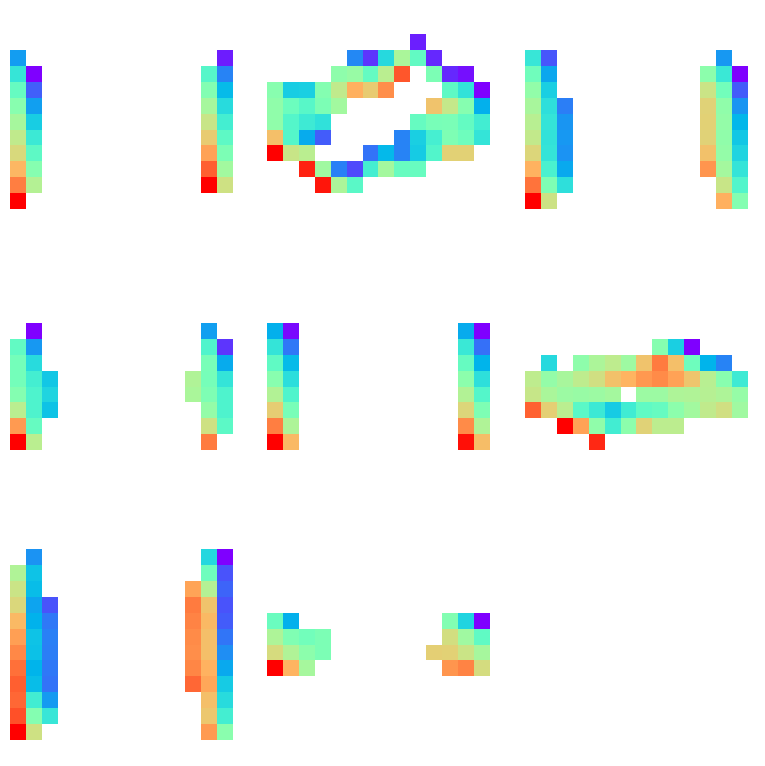

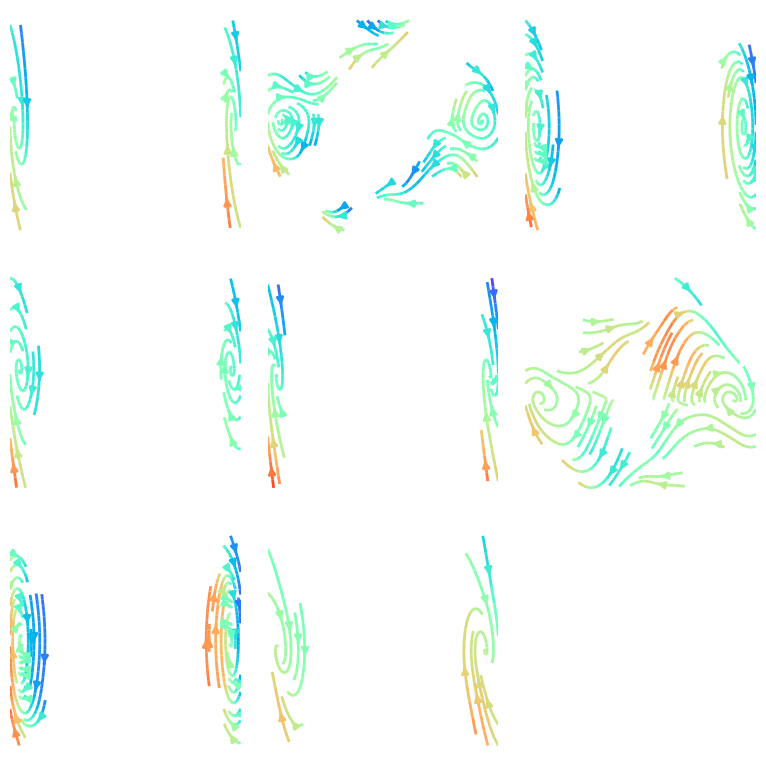

In [29]:
fig1, axs1 = plt.subplots(3, 3, figsize=(8, 8))
fig2, axs2 = plt.subplots(3, 3, figsize=(8, 8))

x, y = np.meshgrid([0, 1, 2], [0, 1, 2])

for i, j, df_gid, my_grid in zip(x.flatten(), y.flatten(), data, global_x_v_a):
    beta = df_gid.beta.iloc[0]
    tau = df_gid.tau.iloc[0]
    D = df_gid.D.iloc[0]
    # axs1[i, j].set_title(rf"$\beta$ = {beta}, $\tau$ = {tau}, $D$ = {D}", y=1.1)
    # axs2[i, j].set_title(rf"$\beta$ = {beta}, $\tau$ = {tau}, $D$ = {D}", y=1.1)

    bounds = my_grid.agg(["min", "max"])
    xmin, xmax = bounds["x"]
    vmin, vmax = bounds["v"]

    acc_map = analysis.map_a(my_grid, nbins, "x_bin", "v_bin", min_pts=2000)

    # PLOT ACC MAP
    im = axs1[i, j].imshow(
        acc_map, origin="lower", interpolation="none", cmap="rainbow"
    )
    axs1[i, j].set_xticks(
        [0, nbins // 2, nbins],
        [round(xmin, 2), round((xmin + xmax) / 2, 2), round(xmax, 2)],
    )
    axs1[i, j].set_yticks(
        [0, nbins // 2, nbins],
        [round(vmin, 2), round((vmin + vmax) / 2, 0), round(vmax, 2)],
    )
    # cbar = fig1.colorbar(im, ax=axs1[i, j])
    # cbar.set_label(r"$F$ ($\mu$m/hr$^2$)")
    # axs1[i, j].set_xlabel(r"$x$ ($\mu$m)")
    # axs1[i, j].set_ylabel(r"$v$ ($\mu$m/hr)")

    # PLOT FLOW LINES
    X, Y = np.meshgrid(np.linspace(xmin, xmax, nbins), np.linspace(vmin, vmax, nbins))

    axs2[i, j].streamplot(
        X, Y, Y, acc_map, linewidth=2, color=acc_map, cmap="rainbow", density=1.5
    )

    axs1[i, j].axis("off")
    axs2[i, j].axis("off")


axs1[2, 2].remove()
axs2[2, 2].remove()

fig1.tight_layout()
# fig1.subplots_adjust(hspace=1)

fig2.tight_layout()
# fig2.subplots_adjust(hspace=1)

plt.show()


In [ ]:
# x = np.linspace(xmin, xmax, 100)
# y = np.linspace(vmin, vmax, 100)
# pts = np.array(list(zip(x, y)))

# try:
#     axs2[i, j].streamplot(X, Y, Y, acc_map, linewidth=2, color=acc_map, cmap="rainbow", start_points=pts, integration_direction="both", density=10)
#     axs2[i, j].set_xlabel(r"$x$ ($\mu$m)")
#     axs2[i, j].set_ylabel(r"$v$ ($\mu$m/hr)")
# except:
#     None

# c = plt.get_cmap("Set2")(3)
# plt.quiver(X, Y, Y, acc_map, np.where(acc_map > 0, 1, 0), cmap="Set2", width=0.007)
# plt.streamplot(X, Y, Y, acc_map, linewidth=2, color=c)
# plt.xlabel(r"$x$ ($\mu$m)")
# plt.ylabel(r"$v$ ($\mu$m/hr)")
# plt.show()